# **Few-Shot Learning for Logical and Structural Detection (GCAD)**

## **Download Dataset**

In [ ]:
!gdown 1FrMzu3EXPei7EeBql-169DuGK3ws2sJO
!tar -xf mvtec_loco_anomaly_detection.tar.xz

In [2]:
! pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 823.7 kB/s eta 0:00:00


## **Import Modules**

In [3]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
from PIL import Image
from einops import rearrange
from sklearn.preprocessing import minmax_scale

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Dataset**

In [4]:
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./', anomaly_type=None, class_name='breakfast_box', mode = 'train',
                 few_shot=1, resize=256,augmentation = False):
        assert class_name in ['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']
        self.class_name = class_name
        assert anomaly_type in [None, 'logical', 'structural']
        self.anomaly_type = anomaly_type
        assert mode in ['train', 'validation', 'test']
        self.mode = mode
        self.resize = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot = few_shot # 1, 2, 4, 8
        self.augmentation = augmentation
        # set transforms
        self.transform_x = T.Compose([T.Resize([resize,resize],interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_x_1 = T.Compose([T.Resize([resize,resize],interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225]),
                                      T.RandomHorizontalFlip(p=1)])
        self.transform_x_2 = T.Compose([T.Resize([resize,resize],interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225]),
                                      T.RandomVerticalFlip(p=1)])
        self.transform_x_3 = T.Compose([T.Resize([resize,resize],interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225]),
                                      T.RandomRotation(degrees = 30,center=(0,0))])
        self.transform_x_4 = T.Compose([T.Resize([resize,resize],interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225]),
                                      T.ColorJitter(brightness=(0.3,1.5))])
        self.transform_mask = T.Compose([T.Resize([resize,resize], interpolation=T.InterpolationMode.NEAREST),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        print(f"{self.class_name} {self.mode} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, self.mode)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            if img_type != 'good' and self.anomaly_type is not None and img_type != self.anomaly_type + '_anomalies':
                    continue
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_dir_list = [os.path.join(gt_type_dir, img_fname) for img_fname in img_fname_list]
                for dir in gt_dir_list:
                    gt_mask = torch.zeros([1, self.resize, self.resize])
                    for f in os.listdir(dir):
                        if f.endswith('.png'):
                            gt_mask = gt_mask + self.transform_mask(Image.open(os.path.join(dir, f)))
                        gt_mask = torch.clip(gt_mask, 0., 1.)
                        mask.append(gt_mask)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and self.mode=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]
            if self.augmentation:
                return_x = []
                return_y = []
                return_mask = []
                return_x.extend([self.transform_x(Image.open(x).convert('RGB')) for x in list(x)])
                return_x.extend([self.transform_x_1(Image.open(x).convert('RGB')) for x in list(x)])
                return_x.extend([self.transform_x_2(Image.open(x).convert('RGB')) for x in list(x)])
                return_x.extend([self.transform_x_3(Image.open(x).convert('RGB')) for x in list(x)])
                return_x.extend([self.transform_x_4(Image.open(x).convert('RGB')) for x in list(x)])
                for i in range(5):
                    return_y.extend(list(y))
                    return_mask.extend([torch.zeros([1, self.resize, self.resize]) if y==0 else mask for y,mask in zip(list(y),list(mask))])
                return return_x,return_y,return_mask

            else:
                return [self.transform_x(Image.open(x).convert('RGB')) for x in list(x)], \
                    list(y), \
                    [torch.zeros([1, self.resize, self.resize]) if y==0 else mask for y,mask in zip(list(y),list(mask))]

        else:
            return [self.transform_x(Image.open(x).convert('RGB')) for x in list(x)], \
                    list(y), \
                    [torch.zeros([1, self.resize, self.resize]) if y==0 else mask for y,mask in zip(list(y),list(mask))]



## **Other Utility Functions**

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def compute_metric(result):
    fpr, tpr, _ = roc_curve(result['total_gt_image'], result['total_scores_image'])
    auc = roc_auc_score(result['total_gt_image'], result['total_scores_image'])
    return fpr, tpr, auc

def plot_roc_curve(fpr, tpr, auc, class_name=''):
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label=f"ROC curve (area = {auc: 0.2f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_name} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def plot_anomaly_map(result, class_name, TestDataset, index, threshold, a_type=None):
    dataset_size = len(TestDataset)
    # Load Testing Input / Ground Truth Mask / Predicted Mask
    input_image = rearrange(result['input_image'][index], 'c h w -> h w c')
    # Denormalize
    input_image[:, : 0] = input_image[:, : 0] * 0.229 + 0.485
    input_image[:, : 1] = input_image[:, : 1] * 0.224 + 0.456
    input_image[:, : 2] = input_image[:, : 2] * 0.225 + 0.406
    input_image = np.clip(input_image, 0., 1.).astype(float)
    gt_mask = rearrange(result['total_gt_pixel'],'b c h w -> (b c) h w')[index]
    if a_type == 'structural':
        predicted_mask = result['structural_map'][index,0]
    elif a_type == 'logical':
        predicted_mask = result['logical_map'][index,0]
    else:
        predicted_mask = result['total_scores_pixel'][index,0]
    predicted_mask = np.where(predicted_mask > threshold, 1., 0.)

    fig, ax = plt.subplots(1, 3)
    fig.suptitle(f'{class_name} Dataset', x=0.5, y=0.72)
    ax[0].imshow(input_image)
    ax[0].set_title('Input')
    ax[1].imshow(gt_mask)
    ax[1].set_title('Ground Truth')
    ax[2].imshow(predicted_mask)
    ax[2].set_title('Predicted')
    plt.tight_layout()
    plt.show()
    return

## Model

paper:https://link.springer.com/article/10.1007/s11263-022-01578-9

### Encoder

In [6]:
from torchvision.models import wide_resnet50_2

# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model, img, outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

# produce multi-scale feature
def concat_feature(features,config):
    use_layers = [i-1 for i in config['use_layers']]
    # determine resize to which feature
    target_size = config['p_size'] # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]

        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html

        temp_feaure = F.interpolate(features[i], (target_size, target_size), mode="bilinear", align_corners=False)
        #############################################################
        resized_feature.append(temp_feaure)

    return torch.concat([resized_feature[i] for i in use_layers],dim=1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 144MB/s]


In [7]:
def encode_loc(encoder,image,config):
    assert len(image.shape) == 4
    ans = torch.zeros((image.shape[0],config['dloc'],image.shape[2],image.shape[3])).to(config['device'])
    for x in range(int(256/config['p_size'])):
        for y in range(int(256/config['p_size'])):
            x_start = x*config['p_size']
            x_end = (x+1)*config['p_size']
            y_start = y*config['p_size']
            y_end = (y+1)*config['p_size']
            local = get_features(encoder,image[:,:,x_start:x_end,y_start:y_end].to(config['device']),outputs)
            local = concat_feature(local,config)
            assert ans[:,:,x_start:x_end,y_start:y_end].shape == local.shape
            ans[:,:,x_start:x_end,y_start:y_end] = local

    return ans

In [8]:
def init_weight(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
    elif isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.xavier_normal_(m.weight)

In [9]:
class feature_encoder(nn.Module):
    def __init__(self,output_dim,g_dim,input_dim = 3):
        super(feature_encoder,self).__init__()
        self.conv = nn.ModuleList([])
        self.deconv = nn.ModuleList([])
        self.skip = nn.ModuleList([])
        self.layers = 6

        out_dim = [32,32,64,64,64]
        out_kernel = [4,4,4,4,4,8]
        self.skip_add = []


        self.conv.append(nn.Sequential(nn.Conv2d(input_dim,out_dim[0],kernel_size=out_kernel[0],stride=2,padding=1),nn.LeakyReLU(0.2)))
        for i in range(self.layers-2):
            self.conv.append(nn.Sequential(nn.Conv2d(out_dim[i],out_dim[i+1],kernel_size=out_kernel[i+1],stride=2,padding=1),nn.LeakyReLU(0.2)))
        self.conv.append(nn.Conv2d(out_dim[self.layers-2],g_dim,kernel_size=out_kernel[self.layers-1]))



        self.deconv.append(nn.ConvTranspose2d(g_dim,out_dim[self.layers-2],kernel_size=out_kernel[self.layers-1]))
        for i in range(self.layers-2):
            self.deconv.append(nn.Sequential(nn.ConvTranspose2d(out_dim[self.layers-2-i],out_dim[self.layers-2-i-1],kernel_size=out_kernel[self.layers-2-i],stride=2,padding=1),nn.LeakyReLU(0.2)))
        self.deconv.append(nn.Sequential(nn.ConvTranspose2d(out_dim[0],32,kernel_size=out_kernel[0],stride=2,padding=1),nn.LeakyReLU(0.2)))
        self.deconv.append(nn.Sequential(nn.ConvTranspose2d(32,output_dim,kernel_size=1,stride=1)))


        for i in range(self.layers-1):
            self.skip.append(nn.Conv2d(out_dim[i],out_dim[i],kernel_size=1,stride=1))
        self.apply(init_weight)
    def forward(self,x,weight=None):
        if weight!=None:
            assert len(weight) == self.layers-1
        self.skip_add = []
        for i in range(self.layers):
            x = self.conv[i](x)
            self.skip_add.append(x)
        for i in range(self.layers-1):
            x = self.deconv[i](x)
            adder = self.skip[self.layers-2-i](self.skip_add[self.layers-2-i])
            if weight!=None:
                x = x + adder * weight[self.layers-2-i]
        x = self.deconv[self.layers-1](x)
        x = self.deconv[self.layers](x)
        return x

### Regressor

https://github.com/jvanvugt/pytorch-unet

In [ ]:
class feature_regressor(nn.Module):
    def __init__(self,output_dim,input_dim = 3,layers = 5):
        super(feature_regressor,self).__init__()
        self.conv = nn.ModuleList([])
        self.deconv = nn.ModuleList([])
        self.skip = nn.ModuleList([])
        self.layers = layers

        out_dim = [64,128,256,512,1024]
        self.skip_add = []


        self.conv.append(nn.Sequential(nn.Conv2d(input_dim,out_dim[0],kernel_size=4,stride=2,padding=1),nn.LeakyReLU(0.2)))
        for i in range(self.layers-2):
            self.conv.append(nn.Sequential(nn.Conv2d(out_dim[i],out_dim[i+1],kernel_size=4,stride=2,padding=1),nn.LeakyReLU(0.2)))
        self.conv.append(nn.Conv2d(out_dim[self.layers-2],out_dim[self.layers-1],kernel_size=1))



        self.deconv.append(nn.ConvTranspose2d(out_dim[self.layers-1],out_dim[self.layers-2],kernel_size=1))

        for i in range(self.layers-2):
            self.deconv.append(nn.Sequential(nn.ConvTranspose2d(out_dim[self.layers-2-i],out_dim[self.layers-2-i-1],kernel_size=4,stride=2,padding=1),nn.LeakyReLU(0.2)))
        self.deconv.append(nn.Sequential(nn.ConvTranspose2d(out_dim[0],output_dim,kernel_size=4,stride=2,padding=1)))


        for i in range(self.layers-1):
            self.skip.append(nn.Conv2d(out_dim[i],out_dim[i],kernel_size=1,stride=1))
        self.apply(init_weight)
    def forward(self,x):
        self.skip_add = []
        for i in range(self.layers):
            x = self.conv[i](x)
            self.skip_add.append(x)
        for i in range(self.layers-1):
            x = self.deconv[i](x)
            adder = self.skip[self.layers-2-i](self.skip_add[self.layers-2-i])
            x = x + adder
        x = self.deconv[self.layers-1](x)
        return x

In [10]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])
        return F.interpolate(self.last(x), 256, mode="bilinear", align_corners=False)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)
        return out

### Upsample

In [11]:
class Upsample(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(Upsample,self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_dim,input_dim,kernel_size=1,stride=1),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(input_dim,output_dim,kernel_size=1,stride=1),
                                  nn.LeakyReLU(0.2),
                                  nn.Conv2d(output_dim,output_dim,kernel_size=1,stride=1))
        self.apply(init_weight)
    def forward(self,x):
        x = self.conv(x)
        return x

### GCAD

In [12]:
class GCAD(nn.Module):
    def __init__(self, config):
        super(GCAD,self).__init__()
        self.eglo = feature_encoder(config['dglo'],config['dim_g'])
        self.U = Upsample(config['dglo'],config['dloc'])
        #self.rglo = UNet(n_classes=config['dglo'],depth=config['r_layer'])
        #self.rloc = UNet(n_classes=config['dloc'],depth=config['r_layer'])
        self.rglo = feature_regressor(config['dglo'],layers=config['r_layer'])
        self.rloc = feature_regressor(config['dloc'],layers=config['r_layer'])
    def forward(self,x,weight=None):
        feature_rloc = self.rloc(x)
        feature_eglo = self.eglo(x,weight)
        feature_rglo = self.rglo(x)
        feature_eglo_up = self.U(feature_eglo)
        return feature_rloc,feature_eglo,feature_rglo,feature_eglo_up
    def predict(self,x,features):
        structural_map = (torch.sum(((features - self.rloc(x))**2),dim=1,keepdim=True)**0.5)
        logical_map = (torch.sum(((self.eglo(x) - self.rglo(x))**2),dim=1,keepdim=True)**0.5)
        return structural_map, logical_map

## **Train/Validation/Test**

### **Train**

In [13]:
def train(encoder, model, dataset, config):

    # optimizer
    rloc_optim = torch.optim.AdamW(model.rloc.parameters(), lr=config['lr_loc'], weight_decay=config['weight'])
    rglo_optim = torch.optim.AdamW(model.rglo.parameters(), lr=config['lr_glo'], weight_decay=config['weight'])
    eglo_optim = torch.optim.Adam(model.eglo.parameters(), lr=config['lr_glo'], weight_decay=config['weight'])
    U_optim = torch.optim.AdamW(model.U.parameters(), lr=config['lr'], weight_decay=config['weight'])
    criterion = nn.MSELoss()
    # train
    weight = [1,1,1,1,1]
    for epoch in tqdm(range(config['epochs'])):
        epoch_loss = 0
        epoch_loc = 0
        epoch_glo = 0
        epoch_kd = 0
        if epoch<config['epochs']/5:
            weight[int(epoch/(config['epochs']/25))]-=25/config['epochs']
        for x,y,mask in DataLoader(dataset, batch_size=config['batch_size']):
            x, y = x.to(config['device']), y.to(config['device'])
            eloc = encode_loc(encoder,x,config)
            eloc2 = eloc.clone()
            rloc,eglo,rglo,up_eglo = model(x,weight)

            loc_loss = criterion(eloc,rloc)
            kd_loss = criterion(eloc2,up_eglo)
            glo_loss = criterion(eglo,rglo)

            loss = loc_loss**0.5/config['dloc']+kd_loss**0.5/config['dloc']+glo_loss**0.5/config['dglo']

            # clear gradient
            if epoch>=config['epochs']/10:
                rglo_optim.zero_grad()
            rloc_optim.zero_grad()
            eglo_optim.zero_grad()
            U_optim.zero_grad()

            # calculate new gradient
            loss.backward()

            # update parameters
            if epoch>=config['epochs']/10:
                rglo_optim.step()
            rloc_optim.step()
            eglo_optim.step()
            U_optim.step()
            epoch_loss += loss.detach().cpu().item()
            epoch_glo += glo_loss.detach().cpu().item()**0.5/config['dglo']
            epoch_loc += loc_loss.detach().cpu().item()**0.5/config['dloc']
            epoch_kd += kd_loss.detach().cpu().item()**0.5/config['dloc']
            del eloc, eloc2, rloc, eglo, rglo, up_eglo
            torch.cuda.empty_cache()
        if (epoch + 1) % config['print_interval'] == 0:
            print(f"epoch{epoch+1} loss:{epoch_loss:.6f}, glo:{epoch_glo:.6f}, loc:{epoch_loc:.6f}, kd:{epoch_kd:.6f}")

### **Test**

In [14]:
#######################################
# testing
@torch.no_grad()
def test(encoder, model, dataset, config):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    result['input_image'] = list()
    result['structural_map'] = list()
    result['logical_map'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=1):
        x, y = x.to(config['device']), y.to(config['device'])
        model.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        eloc = encode_loc(encoder,x,config)

        scores_map = None
        structural_map, logical_map = model.predict(x,eloc)
        result['structural_map'].append(structural_map.cpu().detach().numpy())
        result['logical_map'].append(logical_map.cpu().detach().numpy())

        # store groundtruth
        result['total_gt_pixel'].append(mask.cpu().detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    result['input_image'] = np.concatenate(result['input_image'],axis=0)

    result['structural_map'] = np.concatenate(result['structural_map'],axis=0)
    result['logical_map'] = np.concatenate(result['logical_map'],axis=0)

    mean_structural = np.mean(result['structural_map'],axis = 0,keepdims=True)
    std_structural = np.std(result['structural_map'],axis = 0,keepdims=True)
    mean_logical = np.mean(result['logical_map'],axis = 0,keepdims=True)
    std_logical = np.std(result['logical_map'],axis = 0,keepdims=True)
    result['structural_map'] = (result['structural_map'] - mean_structural)/(std_structural+1e-9)
    result['logical_map'] = (result['logical_map'] - mean_logical)/(std_logical+1e-9)

    if config['anomaly_type'] == 'structural':
        result['total_scores_pixel'] = result['structural_map']

    elif config['anomaly_type'] == 'logical':
        result['total_scores_pixel'] = result['logical_map']

    else:
        result['total_scores_pixel'] = result['logical_map'] + result['structural_map']

    scores = []
    for score_map in result['total_scores_pixel']:
        scores.append(np.max(score_map))

    result['total_scores_image'] = np.array(scores)


    result['total_gt_pixel'] = np.concatenate(result['total_gt_pixel'],axis=0)
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    model.train()
    return result

## **Training/Testing Process**

### **Config**

In [15]:
config = {
    'few_shot' : 8,
    'anomaly_type' : None, # None, 'logical', 'structural'
    'lr':1e-4,
    'lr_loc':1e-4,
    'lr_glo':1e-4,
    'r_layer':5,#adjustable[3,4,5]
    'weight':1e-5,
    'epochs' : 20,
    'print_interval' : 10,
    'batch_size' : 1,
    'device' : device,
    'use_layers' : [1,2,3],#with dloc [0:1024,1:256,2:512,3:1024]
    'p_size':16,#adjustable[16,32]
    'dglo':60,#adjustable[10,140]
    'dloc':1792,#adjustable with use_layers
    'dim_g':32,#adjustable[16,32,48,64]
}

### **Training and Testing**

In [16]:
datasets = {}
class_names = ['breakfast_box', 'juice_bottle', 'pushpins', 'screw_bag', 'splicing_connectors']
modes = ['train', 'validation', 'test']

In [17]:
for class_name in ['breakfast_box']:
    datasets[class_name] = {}
    for mode in ['train', 'test']:
        datasets[class_name][mode] = MVTecDataset(class_name=class_name, anomaly_type=config['anomaly_type'], mode=mode, few_shot=config['few_shot'],augmentation=True)

breakfast_box train dataset created, consists of 40 images
breakfast_box test dataset created, consists of 275 images


In [ ]:
for class_name in ['juice_bottle']:
    datasets[class_name] = {}
    for mode in ['train', 'test']:
        datasets[class_name][mode] = MVTecDataset(class_name=class_name, anomaly_type=config['anomaly_type'], mode=mode, few_shot=config['few_shot'],augmentation=True)

juice_bottle train dataset created, consists of 40 images
juice_bottle test dataset created, consists of 330 images


In [ ]:
for class_name in ['pushpins']:
    datasets[class_name] = {}
    for mode in ['train', 'test']:
        datasets[class_name][mode] = MVTecDataset(class_name=class_name, anomaly_type=config['anomaly_type'], mode=mode, few_shot=config['few_shot'],augmentation=True)

pushpins train dataset created, consists of 40 images
pushpins test dataset created, consists of 310 images


In [ ]:
for class_name in ['screw_bag']:
    datasets[class_name] = {}
    for mode in ['train', 'test']:
        datasets[class_name][mode] = MVTecDataset(class_name=class_name, anomaly_type=config['anomaly_type'], mode=mode, few_shot=config['few_shot'],augmentation=True)

screw_bag train dataset created, consists of 40 images
screw_bag test dataset created, consists of 341 images


In [ ]:
for class_name in ['splicing_connectors']:
    datasets[class_name] = {}
    for mode in ['train', 'test']:
        datasets[class_name][mode] = MVTecDataset(class_name=class_name, anomaly_type=config['anomaly_type'], mode=mode, few_shot=config['few_shot'],augmentation=True)

splicing_connectors train dataset created, consists of 40 images
splicing_connectors test dataset created, consists of 312 images


**breakfast_box**

In [18]:
model = GCAD(config).to(device)
train(encoder, model, datasets['breakfast_box']['train'], config)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch10 loss:0.014949, glo:0.007884, loc:0.003430, kd:0.003635
epoch20 loss:0.010402, glo:0.003453, loc:0.003316, kd:0.003633


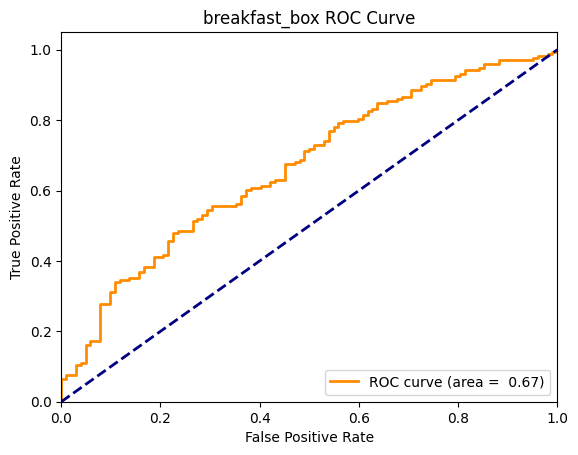

In [19]:
result = test(encoder, model, datasets['breakfast_box']['test'], config)
fpr, tpr, auc = compute_metric(result)
plot_roc_curve(fpr, tpr, auc, 'breakfast_box')

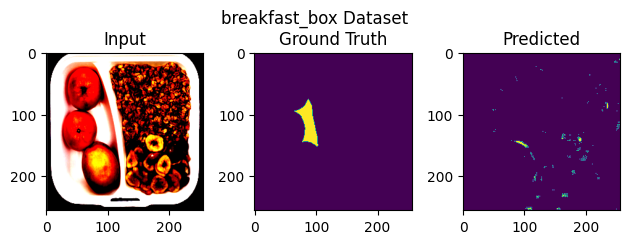

In [46]:
anomaly_threshold = 3
# Get a random sample
# index = int(np.random.random()*len(result['input_image']))
index = 200
plot_anomaly_map(result, 'breakfast_box', datasets['breakfast_box']['test'], index, anomaly_threshold)

**juice_bottle**

In [ ]:
model = GCAD(config).to(device)
train(encoder, model, datasets['juice_bottle']['train'], config)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch10 loss:0.012752, glo:0.007020, loc:0.002713, kd:0.003019
epoch20 loss:0.009176, glo:0.003814, loc:0.002466, kd:0.002896


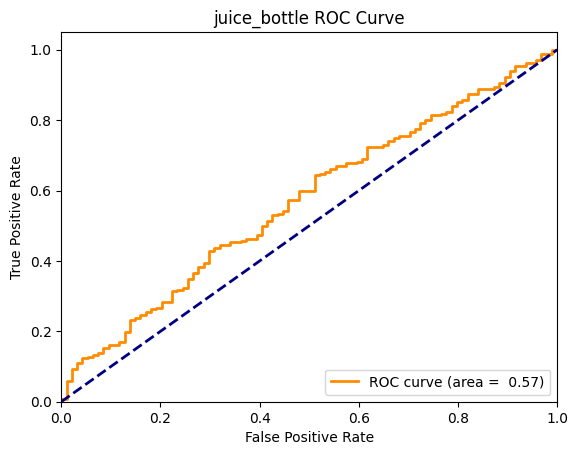

In [ ]:
result = test(encoder, model, datasets['juice_bottle']['test'], config)
fpr, tpr, auc = compute_metric(result)
plot_roc_curve(fpr, tpr, auc, 'juice_bottle')

**pushpins**

In [ ]:
model = GCAD(config).to(device)
train(encoder, model, datasets['pushpins']['train'], config)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch10 loss:0.013563, glo:0.006899, loc:0.003257, kd:0.003407
epoch20 loss:0.009783, glo:0.003367, loc:0.003015, kd:0.003401


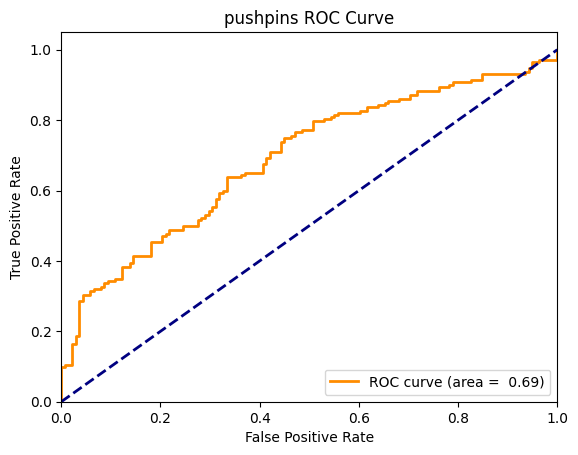

In [ ]:
result = test(encoder, model, datasets['pushpins']['test'], config)
fpr, tpr, auc = compute_metric(result)
plot_roc_curve(fpr, tpr, auc, 'pushpins')

**screw_bag**

In [ ]:
model = GCAD(config).to(device)
train(encoder, model, datasets['screw_bag']['train'], config)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch10 loss:0.013228, glo:0.007164, loc:0.002978, kd:0.003086
epoch20 loss:0.009433, glo:0.003635, loc:0.002720, kd:0.003078


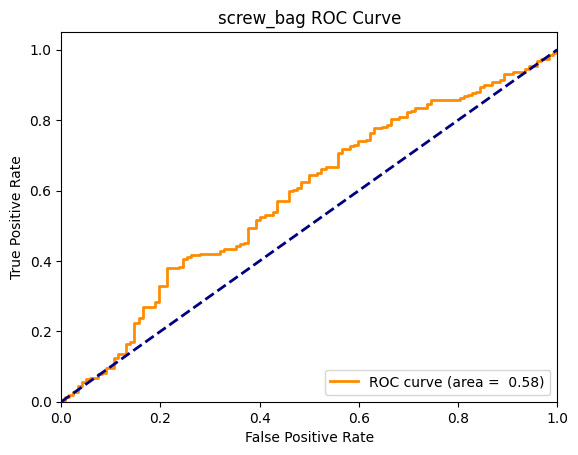

In [ ]:
result = test(encoder, model, datasets['screw_bag']['test'], config)
fpr, tpr, auc = compute_metric(result)
plot_roc_curve(fpr, tpr, auc, 'screw_bag')

**splicing_connectors**

In [ ]:
model = GCAD(config).to(device)
train(encoder, model, datasets['splicing_connectors']['train'], config)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch10 loss:0.015354, glo:0.008299, loc:0.003355, kd:0.003700
epoch20 loss:0.010252, glo:0.003402, loc:0.003154, kd:0.003695


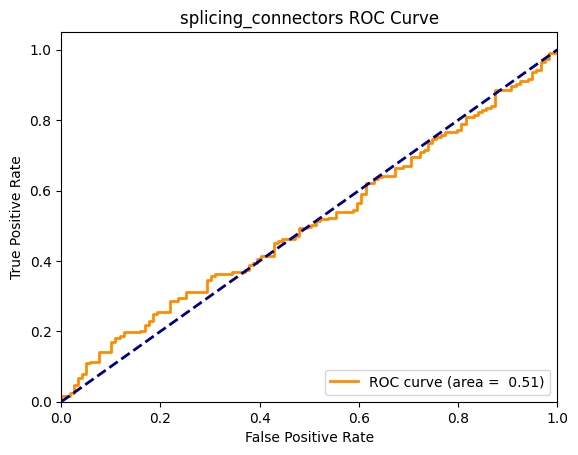

In [ ]:
result = test(encoder, model, datasets['splicing_connectors']['test'], config)
fpr, tpr, auc = compute_metric(result)
plot_roc_curve(fpr, tpr, auc, 'splicing_connectors')

need to delete model / result in each training process, to avoid the lack of ram

In [ ]:
del model
del result

## Find best hyperparameters

In [ ]:

best_auc = -1
best_dglo, best_dloc, best_dim_g = 0, 0, 0
class_name = 'breakfast_box'

for dglo in [60, 70, 80, 90]:
    config['dglo'] = dglo
    for dim_g in [16, 32, 48, 64]:
        config['dim_g'] = dim_g
        model = GCAD(config).to(device)
        train(encoder, model, datasets[class_name]['train'], config)
        result = test(encoder, model, datasets[class_name]['test'], config)
        fpr, tpr, auc = compute_metric(result)
        del model
        del result

        if best_auc < auc:
            best_auc = auc
            best_dglo = dglo
            best_dim_g = dim_g

# output: best_dglo = 90, best_dim_g = 48, best_dim_g2 = 1024, auc = 0.56